In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Проверка корректности загрузки данных (совпадение размерностей, визуальное отображение выборочных данных).

In [3]:
def show_imgs(title, images, tags):

    length_imgs = 5

    fig, ax = plt.subplots(length_imgs, length_imgs,  sharex=True)
    fig.suptitle('Пример {} данных:'.format(title))
    
    for i, ax in enumerate(ax.flat):
        img = images[i]
        ax.imshow(img, cmap = 'gray', vmin=0, vmax=255)
        ax.text(0, 7, str(tags[i]), color = 'y', fontsize = 'medium')

Количество тренировочных данных: 60000


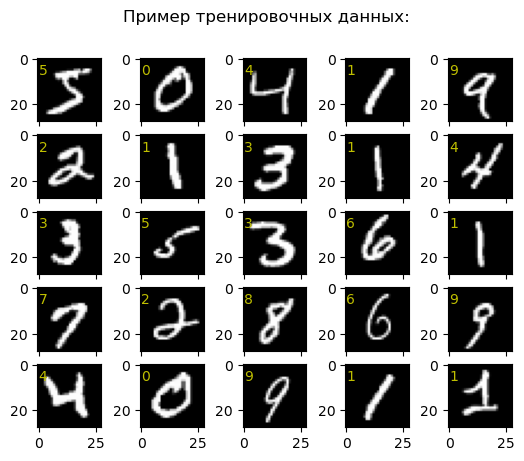

In [4]:
show_imgs('тренировочных', x_train, y_train)

print('Количество тренировочных данных: {}'.format(len(x_train)))

Количество тестовых данных: 10000


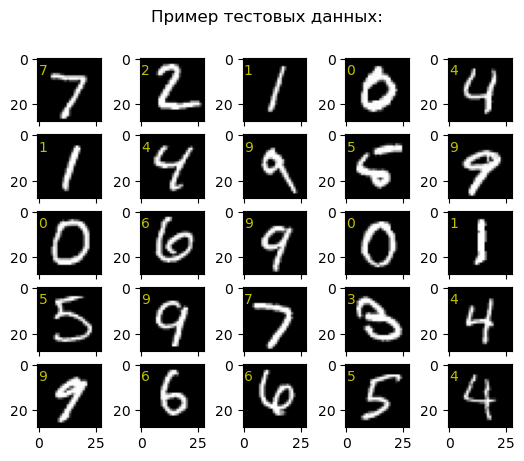

In [5]:
show_imgs('тестовых', x_test, y_test)

print('Количество тестовых данных: {}'.format(len(x_test)))

In [6]:
print('Размерность входа:')
print('Тренировочная выборка: {}'.format(x_train.shape) +  ', Тестовая выборка: {}'.format(x_test.shape))
print('Тип входных данных: {}'.format(x_train.dtype))

Размерность входа:
Тренировочная выборка: (60000, 28, 28), Тестовая выборка: (10000, 28, 28)
Тип входных данных: uint8


In [7]:
print('Размерность маркеров:')
print('Тренировочная выборка: {}'.format(y_train.shape) +  ', Тестовая выборка: {}'.format(y_test.shape))

Размерность маркеров:
Тренировочная выборка: (60000,), Тестовая выборка: (10000,)


In [8]:
w = x_train.shape[1]
h = x_train.shape[2]

train_x = x_train.reshape(x_train.shape[0], w * h)
test_x = x_test.reshape(x_test.shape[0], w * h)

# преобразование типов
train_x = train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255

# преобразование маркеров для удобства
classes = 10
train_y = np.eye(classes)[y_train]
test_y = np.eye(classes)[y_test]

In [9]:
train_y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [10]:
y_train[0]

5

In [11]:
print('Размерность входа:')
print('Тренировочная выборка: {}'.format(train_x.shape) +  ', Тестовая выборка: {}'.format(test_x.shape))
print('Размерность маркеров:')
print('Тренировочная выборка: {}'.format(train_y.shape) +  ', Тестовая выборка: {}'.format(test_y.shape))

Размерность входа:
Тренировочная выборка: (60000, 784), Тестовая выборка: (10000, 784)
Размерность маркеров:
Тренировочная выборка: (60000, 10), Тестовая выборка: (10000, 10)


In [12]:
# функции активации

def reLU(v):
    return np.maximum(v, 0)
    
def softmax(z):
    exp_z = np.exp(z)
    exp_z_sum = np.sum(exp_z, axis=1, keepdims=True)
    return exp_z / exp_z_sum
    
# функция ошибки
# на нескольких объектах кросс-энтропия это среднее, потому что это сумма кросс-энтр для каждого объекта поделенная на L

def cross_entropy(u, y):
    return np.mean(- 1 * y * np.log(u))
    
# совпадения

def accuracy(u, y):
    return np.mean(np.argmax(u, axis = 1) == np.argmax(y, axis = 1))


In [13]:
# прямой проход, вычисление значений выходных сигналов

def forward(x, w1, w2, a, b):
    f = np.dot(x, w1) + a
    v = reLU(f)
    g = np.dot(v, w2) + b
    u = softmax(g)
    return f, v, u


# обратный проход и корректировка весов

def backward(x, f, y, u, v, w1, w2, a, b, learning_rate, batch_size):
    delta2 = (u - y) / batch_size
    
    dw2 = np.dot(v.T, delta2)
    
    dReLU = np.where(f > 0, 1, 0)
    
    delta1 = np.dot(delta2, w2.T) * dReLU
    
    dw1 = np.dot(x.T, delta1)
    
    # из-за батча    
    da = np.sum(delta1, axis=0, keepdims=True)
    db = np.sum(delta2, axis=0, keepdims=True)
    
    w1 -= learning_rate * dw1
    w2 -= learning_rate * dw2
    a -= learning_rate * da
    b -= learning_rate * db
    
    return w1, w2, a, b

In [14]:
def output_results(epoch, u, y, time):
    acc = accuracy(u, y)
    print('Эпоха {}: Точность = {:.6f}, Ошибка = {:.6f}'.format(epoch, acc, 1-acc))
    print('Время: {:.6f}s'.format(time))

In [15]:
def train(x, y, num_epochs = 20, batch_size = 20, 
          learning_rate = 0.1, hidden_layers = 300, 
          num_classes = 10, image_resolution = 28 * 28):
    
    start = time.time()
    # что-то вроде нормального распределения, чтобы веса небольшие и отличные от 0 были
    w1 =  np.random.randn(image_resolution, hidden_layers) * 0.01
    w2 = np.random.randn(hidden_layers, num_classes) * 0.01
    a = np.zeros((1, hidden_layers))
    b = np.zeros((1, num_classes))
    
    for i in range(num_epochs):
            s_epoch = time.time()
            
            # разбиваем тренировочные данные на батчи, тренируемся, корректируем веса
            for j in range(0, len(x), batch_size):
                x_cur = x[j : j + batch_size]
                y_cur = y[j : j + batch_size]
                
                f_cur, v_cur, u_cur = forward(x_cur, w1, w2, a, b)
                
                w1, w2, a, b = backward(x_cur, f_cur, y_cur, u_cur, 
                                        v_cur, w1, w2, a, b, 
                                        learning_rate, batch_size)
                
            # считаем точность на выборке    
            _, _, u = forward(x, w1, w2, a, b)
            end_epoch = time.time() - s_epoch
            output_results(i, u, y, end_epoch)
    end = time.time() - start
    
    print('Затраченное время: {}'.format(end))
    
    return w1, w2, a, b
    
def test(x, y, w1, w2, a, b):
    _, _, u = forward(x, w1, w2, a, b)
    acc = accuracy(u, y)
    
    print('Точность = {:.6f}, Ошибка = {:.6f}'.format(acc, 1 - acc))

# По окончании каждой эпохи в процессе обучения модели выводится ошибка классификации на тренировочном наборе данных.

# По окончании эпохи в процессе обучения выводится время эпохи.

#

In [16]:
w1, w2, a, b = train(train_x, train_y)

Эпоха 0: Точность = 0.949250, Ошибка = 0.050750
Время: 6.218562s
Эпоха 1: Точность = 0.970267, Ошибка = 0.029733
Время: 6.335835s
Эпоха 2: Точность = 0.977383, Ошибка = 0.022617
Время: 6.396324s
Эпоха 3: Точность = 0.982167, Ошибка = 0.017833
Время: 6.435358s
Эпоха 4: Точность = 0.986017, Ошибка = 0.013983
Время: 7.048064s
Эпоха 5: Точность = 0.988183, Ошибка = 0.011817
Время: 7.062733s
Эпоха 6: Точность = 0.990150, Ошибка = 0.009850
Время: 8.289913s
Эпоха 7: Точность = 0.991450, Ошибка = 0.008550
Время: 7.254902s
Эпоха 8: Точность = 0.992567, Ошибка = 0.007433
Время: 6.946378s
Эпоха 9: Точность = 0.994333, Ошибка = 0.005667
Время: 6.628841s
Эпоха 10: Точность = 0.995033, Ошибка = 0.004967
Время: 6.838938s
Эпоха 11: Точность = 0.995617, Ошибка = 0.004383
Время: 7.325870s
Эпоха 12: Точность = 0.996417, Ошибка = 0.003583
Время: 6.697674s
Эпоха 13: Точность = 0.996983, Ошибка = 0.003017
Время: 6.965893s
Эпоха 14: Точность = 0.997967, Ошибка = 0.002033
Время: 6.559938s
Эпоха 15: Точность =

# После обучения выводится ошибка классификации на тестовом наборе данных.

In [17]:
test(test_x, test_y, w1, w2, a, b)

Точность = 0.982300, Ошибка = 0.017700
